# This notebook demonstrates the analysis of the whole-brain light sheet imagining data of larval zebrafish using several spectral analysis techniques, to discover and model the locomotion-respiratory coupling mechanism

## Implemented by Anuththara Rupasinghe

# Import Packages

In [1]:
# Package imports

import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
from scipy import stats
from scipy.signal import windows, freqz
from scipy.stats.distributions import chi2
import h5py    

%matplotlib inline

# Specify the Path to your files

In [2]:
# Specify the path to your files

efile = 'D:\\Misha data\\20200204_huc_GC7f\\1_HuC_GC7f_GFAP_RGECO_5dpf-TS10-plane11_15ms_20200204_211717\\1_HuC_GC7f_GFAP_RGECO_5dpf-TS10-plane11.10chFlt'
imaging_file = 'D:\\Misha data\\20200204_huc_GC7f\\1_HuC_GC7f_GFAP_RGECO_5dpf-TS10-plane11_15ms_20200204_211717\\cell_dff.h5'

# Change these values to suit the dataset
threshold_EMG_binary = 0.0004 # adjust according to the dataset
threshold_EMG = 0.00001 # adjust according to the dataset
fs = 1.33*50 # Specify the sampling frequency of flouresence observations

# set to 1 for swim oscillations
observe_swimming = 0

# Loading imaging data into the workspace

In [3]:
# loading imaging data into the workspace

f = h5py.File(imaging_file, 'r')
list(f.keys())

data1 = f[list(f.keys())[0]]

data2 = f[list(f.keys())[1]]

flouresence = f[list(f.keys())[2]]


In [4]:
def moving_avg(x,w):
    return np.convolve(x, np.ones(w), 'same')/w

# Extract ephys

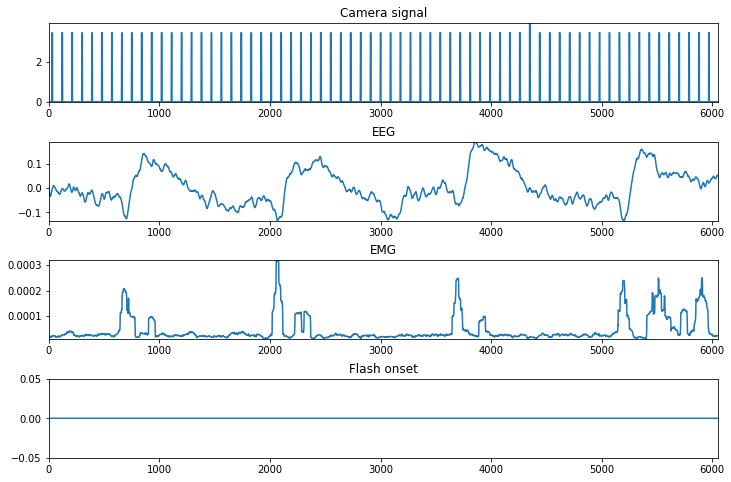

In [5]:
# extract ephys

with open(efile, 'rb') as fid:
    X = np.fromfile(fid, dtype = 'float32')
    
EEG=X[1::10] # breathing
EMG = X[0::10] # swimming

EMG_smooth = moving_avg((EMG - moving_avg(EMG,60))**2,60)

Camera_on_off = X[2::10]
Camera_on = np.zeros((Camera_on_off.shape[0]))
Camera_on[1::] = (np.diff((Camera_on_off > 3)*1) > 0)*1     

Flash = X[4::10]
Flash_on = np.zeros((Flash.shape[0]))
Flash_on[1::] = (np.diff((Flash > 0)*1) > 0)*1     

K0 = (np.floor(EEG.shape[0]/200)).astype(int)
K1 = (np.floor(EEG.shape[0]/150)).astype(int)

plt.figure(figsize=(12,8))
plt.subplot(4, 1, 1)
plt.plot(Camera_on_off[K0:K1])
plt.autoscale(enable=True, tight=True)
plt.title('Camera signal')
plt.subplot(4, 1, 2)
plt.plot(EEG[K0:K1])
plt.autoscale(enable=True, tight=True)
plt.title('EEG')
plt.subplot(4, 1, 3)
plt.plot(EMG_smooth[K0:K1])
plt.autoscale(enable=True, tight=True)
plt.title('EMG')
plt.subplot(4, 1, 4)
plt.plot(Flash_on[K0:K1])
plt.autoscale(enable=True, tight=True)
plt.title('Flash onset')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
plt.show()

# Process and downsample the Ephys to the rate of imaging data

In [6]:
# Process and downsample the EEG, EMG and Flash to the rate of imaging data

no_of_planes = len(np.unique(data2[:,0]))
on_window_size = 5 # number of samples that the Camera is on

EMG_binary = (EMG_smooth > threshold_EMG_binary)*1 # Finding swim onset

EEG_downsampled_temp = np.zeros(((np.sum(Camera_on, axis = 0)).astype(int)))
EMG_downsampled_temp = np.zeros(((np.sum(Camera_on, axis = 0)).astype(int)))
EMG_downsampled_binary_temp = np.zeros(((np.sum(Camera_on, axis = 0)).astype(int)))
Flash_downsampled_temp =  np.zeros(((np.sum(Camera_on, axis = 0)).astype(int))) # Keeps track of flash on
track_flash = np.zeros((Flash.shape[0])) # Keeps track of Camera on events
Flash_downsampled_temp2 =  np.zeros(((np.sum(Camera_on, axis = 0)).astype(int))) # Keeps track of flash

# number of samples between 2 camera on events
temp, = np.where(Camera_on == 1)
half_wind = (np.floor((temp[1] - temp[0])/2)).astype(int)

# extract the ephys at the camera on events
count = -1
for k in range(0,Camera_on.shape[0]):
    if Camera_on[k] > 0.5 and count < EEG_downsampled_temp.shape[0]:
        count = count + 1
        EMG_downsampled_binary_temp[count] = (np.sum(EMG_binary[k:k+2*half_wind]) > 0)*1
        EEG_downsampled_temp[count] = EEG[k]
        Flash_downsampled_temp[count] = np.nanmax(np.abs(Flash_on[k:k+2*half_wind]))
        EMG_downsampled_temp[count] = np.maximum(np.nanmax(np.abs(EMG_smooth[k:k+2*half_wind])), threshold_EMG) - threshold_EMG
        if Flash_downsampled_temp[count] > 0:
            track_flash[k] = 1
        Flash_downsampled_temp2[count] = np.nanmax(np.abs(Flash[k:k+2*half_wind]))

K = flouresence.shape[1]

# Initiating variables
EEG_downsampled_planes = np.zeros((K,no_of_planes))
EMG_downsampled_planes = np.zeros((K,no_of_planes))
EMG_binary_downsampled_planes = np.zeros((K,no_of_planes))
Flash_downsampled_planes = np.zeros((K,no_of_planes))

if no_of_planes > 1:
    EMG_downsampled_binary1 = EMG_downsampled_binary_temp[0::no_of_planes+1]
    EMG_downsampled1 = EMG_downsampled_temp[0::no_of_planes+1]
    EMG_downsampled1 = EMG_downsampled1[0:K]
    EEG_downsampled1 = EEG_downsampled_temp[0::no_of_planes+1]
    EEG_downsampled1 = EEG_downsampled1[0:K]
    Flash_downsampled1 = Flash_downsampled_temp[0::no_of_planes+1]
    Flash_downsampled1 = Flash_downsampled1[0:K]
    Flash_downsampled2 = Flash_downsampled_temp2[0::no_of_planes+1]
    Flash_downsampled2 = Flash_downsampled2[0:K]

    # Extracting ephys in each plane
    for plane in range(0,no_of_planes):
        temp_flash1 = Flash_downsampled_temp[1+plane::no_of_planes+1]
        Flash_downsampled1 = Flash_downsampled1 + temp_flash1[0:K]
        temp_EMG_downsampled1 = EMG_downsampled_temp[1+plane::no_of_planes+1]
        EMG_downsampled1 = EMG_downsampled1 + temp_EMG_downsampled1[0:K]
        temp_EEG = EEG_downsampled_temp[1+plane::no_of_planes+1]
        EEG_downsampled_planes[:,plane] = temp_EEG[0:K]
        temp_EMG = EMG_downsampled_temp[1+plane::no_of_planes+1]
        EMG_downsampled_planes[:,plane] = temp_EMG[0:K]
        temp_EMG_bin = EMG_downsampled_binary_temp[1+plane::no_of_planes+1]
        EMG_binary_downsampled_planes[:,plane] = temp_EMG_bin[0:K]
        temp_flash = Flash_downsampled_temp[1+plane::no_of_planes+1]
        Flash_downsampled_planes[:,plane] = temp_flash[0:K]

    Flash_downsampled1 = (Flash_downsampled1>0)*1
    EMG_downsampled1 = EMG_downsampled1/(no_of_planes+1)

    EMG_downsampled_binary = EMG_downsampled_binary1[0:K]
    EEG_downsampled = EEG_downsampled1[0:K]
    EMG_downsampled = EMG_downsampled1[0:K]

    Flash_downsampled = Flash_downsampled1[0:K]
    Flash_downsampled_all = Flash_downsampled2[0:K]
else:
    EMG_downsampled_binary = EMG_downsampled_binary_temp[0:K]
    EMG_downsampled = EMG_downsampled_temp[0:K]
    Flash_downsampled = Flash_downsampled_temp[0:K]
    Flash_downsampled_all = Flash_downsampled_temp2[0:K]
    EEG_downsampled = EEG_downsampled_temp[0:K]
    EEG_downsampled_planes[:,0] = EEG_downsampled
    
EMG_downsampled_binary = EMG_downsampled_binary + (EMG_downsampled > threshold_EMG_binary)*1
EMG_downsampled_binary = (EMG_downsampled_binary > 0)*1     

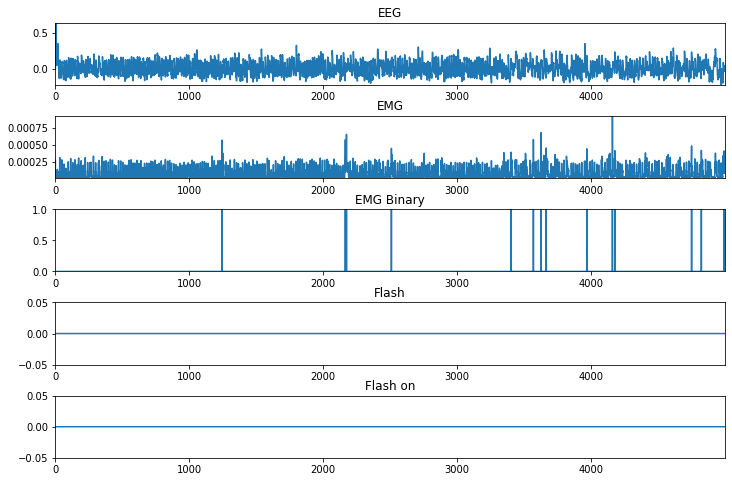

In [7]:
K1 = 5000

plt.figure(figsize=(12,8))
plt.subplot(5, 1, 1)
plt.plot(EEG_downsampled[0:K1])
plt.autoscale(enable=True, tight=True)
plt.title('EEG')
plt.subplot(5, 1, 2)
plt.plot(EMG_downsampled[0:K1])
plt.autoscale(enable=True, tight=True)
plt.title('EMG')
plt.subplot(5, 1, 3)
plt.plot(EMG_downsampled_binary[0:K1])
plt.autoscale(enable=True, tight=True)
plt.title('EMG Binary')
plt.subplot(5, 1, 4)
plt.plot(Flash_downsampled_all[0:K1])
plt.autoscale(enable=True, tight=True)
plt.title('Flash')
plt.subplot(5, 1, 5)
plt.plot(Flash_downsampled[0:K1])
plt.autoscale(enable=True, tight=True)
plt.title('Flash on')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
plt.show()   

# Finding the swim in each time window and ranking

In [8]:
# Finding the swim in each time window and ranking

W = (np.floor(fs*4)).astype(int) # The length of each window (I have chosen 1 minute in this case)
M_all = (np.floor(K/W)).astype(int) # Total number of time windows

swim_effect = 1 # 2 seconds before and 2 seconds after swim events
EMG_window_act = np.zeros((M_all))
Flash_window_act = np.zeros((M_all))

for m in range(0,M_all):
    if m == 0:
        EMG_window_act[m] = np.sum(EMG_downsampled_binary[m*W: (m+1)*W + (np.floor(fs*swim_effect)).astype(int)])
    elif m == M_all:
        EMG_window_act[m] = np.sum(EMG_downsampled_binary[m*W - (np.floor(fs*swim_effect)).astype(int): (m+1)*W ])
    else:
        EMG_window_act[m] = np.sum(EMG_downsampled_binary[m*W - (np.floor(fs*swim_effect)).astype(int): (m+1)*W + (np.floor(fs*swim_effect)).astype(int)])
    Flash_window_act[m] = np.sum(Flash_downsampled_all[m*W : (m+1)*W ])

swim_order_temp =  (np.argsort(EMG_window_act)).astype(int) # The variable swim_order has the windows ranked according to increasing swim activity

flag1 = 0
for i in range(0,swim_order_temp.shape[0]):
    if Flash_window_act[swim_order_temp[i]] == 0:
        if flag1 == 0:
            swim_order = swim_order_temp[i]
            EMG_window_act_no_flash = EMG_window_act[swim_order_temp[i]]
            flag1 = 1
        else:
            swim_order = np.append(swim_order,swim_order_temp[i])
            EMG_window_act_no_flash = np.append(EMG_window_act_no_flash,EMG_window_act[swim_order_temp[i]])

# Flip the order if analyzing swimming conditions
if observe_swimming == 1:
    swim_order = np.flip(swim_order)
    
temp, = np.where(EMG_window_act_no_flash == 0)
M_analysed = (temp).shape[0] # Select how many windows you need to analyse

print(M_analysed)


31


# Finding EEG oscillation frequency in each time window

In [9]:
N = 256*1 # number of frequency bins between 0-fs/2 Hz 
N_max = (np.floor(N*5/(0.5*fs))).astype(int)
NW = 3 # time half-bandwidth product of Multitapering
no_of_tapers = 5 # the number of tapers considered for Multitapering
dpss_seq = scipy.signal.windows.dpss(W, NW, Kmax=no_of_tapers) # Generate the data tapers used for multitapering

Fourier_est_eeg = np.zeros((2*N, M_all,no_of_planes,no_of_tapers),dtype=complex)
PSD_eeg_taper = np.zeros((2*N, M_all,no_of_planes,no_of_tapers))

for plane in range(0,no_of_planes):
    for taper in range(0,no_of_tapers):
        for m in range(0,M_all):
            s2 = EEG_downsampled_planes[m*W:(m+1)*W,plane]
            temp = (s2 - np.mean(s2)).T*dpss_seq[taper,:]
            Fourier_est_eeg[:,m,plane,taper] = ((np.fft.fft(temp, n = 2*N)).T).reshape((2*N,)) # Eigen spectra of the tapered process
            PSD_eeg_taper[:,m,plane,taper] = (np.absolute(Fourier_est_eeg[:,m,plane,taper]))**2 # Eigenspectral estimates

PSD_eeg_multitaper = np.mean(PSD_eeg_taper,axis=3)

N_eeg_all = np.argmax(np.mean(10*np.log10(PSD_eeg_multitaper[0:N_max,:,:]),axis=2), axis=0)

f_eeg_all = N_eeg_all*fs/(2*N) # This variable records the EEG oscillation freqency at each time window


# Plot all images cells

<function matplotlib.pyplot.show(*args, **kw)>

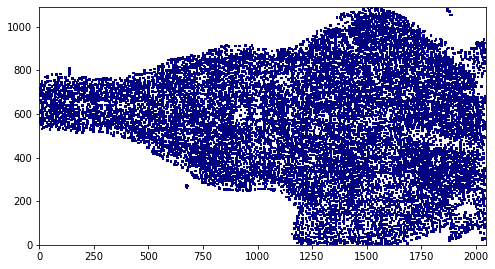

In [10]:
# Plot all cells observed

import numpy.matlib               

hh=np.matlib.repmat(np.arange(100),100,1)
vv=hh.T

com_y = np.zeros((data1.shape[0]))
com_x = np.zeros((data1.shape[0]))

for c in range(0,data1.shape[0]):
    com_y[c] = (np.sum(data1[c,:,:]*vv)/np.sum(data1[c,:,:])).astype(int)
    com_x[c] = (np.sum(data1[c,:,:]*hh)/np.sum(data1[c,:,:])).astype(int)

x_loc=(data2[:,2]+com_x).astype(int)
y_loc=(data2[:,1]+com_y).astype(int)

plt.figure(figsize=(8,5))
shift = 4
spaceMap=np.nan*np.ones(((np.ceil(np.max(y_loc+1))).astype(int),(np.ceil((np.max(x_loc+1)))).astype(int)))
for c in range(0,flouresence.shape[0]):
    if np.isnan(spaceMap[y_loc[c],x_loc[c]]):
        spaceMap[(np.maximum(np.ceil(y_loc[c]-shift).astype(int),1)).astype(int):(np.minimum(np.ceil(y_loc[c]+shift),(np.ceil(np.max(y_loc+1))).astype(int))).astype(int), (np.maximum(np.ceil(x_loc[c]-shift),1)).astype(int):(np.minimum(np.ceil(x_loc[c]+shift),(np.ceil(np.max(x_loc+1))).astype(int))).astype(int)] = 1
plt.pcolor(spaceMap,cmap="jet")
plt.gca().set_aspect('equal')
plt.show

# Find coherence of all cells wrt EEG

In [11]:
# Find cells having significant coherence with EEG

cells_all = flouresence.shape[0]

coherence_est_cells = np.zeros((cells_all)) # records the average coherence of each cell
CPSD_cells_with_EEG = np.zeros((cells_all,M_analysed),dtype=complex) # records the cross PSD with EEG

shift = 10

for c in range(0,cells_all):
#     for c in range(0,10):
    if c % 2000 == 0:
        print("No of cells analyzed: ",c)
    plane_cell = data2[c,0]
    cross_eeg = 0 + 0j
    PSD_temp = 0
    temp_indices, = np.where(((np.maximum(np.ceil(y_loc[c]-shift).astype(int),1)).astype(int) <= y_loc) & ((np.minimum(np.ceil(y_loc[c]+shift),(np.ceil(np.max(y_loc+1))).astype(int))).astype(int) >= y_loc) & ((np.maximum(np.ceil(x_loc[c]-shift).astype(int),1)).astype(int) <= x_loc) & ((np.minimum(np.ceil(x_loc[c]+shift),(np.ceil(np.max(x_loc+1))).astype(int))).astype(int) >= x_loc) & (data2[:,0] == plane_cell))
#     if len(temp_indices)==0:
#         temp_indices = [c]
    for m_temp in range(0,M_analysed):
        m = swim_order[m_temp]
        for taper in range(0,no_of_tapers):
            if len(temp_indices) == 1:
                signal = flouresence[temp_indices,m*W:(m+1)*W]
                signal = signal.reshape((W,))
            else:
                signal = np.mean(flouresence[temp_indices,m*W:(m+1)*W], axis = 0)
            temp = (signal - np.mean(signal))*dpss_seq[taper,:]
            Fourier_est_temp = ((np.fft.fft(temp, n = 2*N)).T).reshape((2*N,)) 
            cross_eeg = cross_eeg + Fourier_est_temp[N_eeg_all[m]] * np.conj(((Fourier_est_eeg[N_eeg_all[m],m,plane_cell,taper])))
            PSD_temp = PSD_temp +  (np.absolute(Fourier_est_temp[N_eeg_all[m]]))**2
        cross_eeg = (1/no_of_tapers)*cross_eeg
        CPSD_cells_with_EEG[c,m_temp] = cross_eeg
        PSD_temp = (1/no_of_tapers)*PSD_temp
        coherence_est_cells[c] = coherence_est_cells[c] + (np.absolute(cross_eeg))**2/(PSD_temp * PSD_eeg_multitaper[N_eeg_all[m],m,plane_cell])

coherence_est_cells = (1/M_analysed)*coherence_est_cells

No of cells analyzed:  0
No of cells analyzed:  2000
No of cells analyzed:  4000
No of cells analyzed:  6000
No of cells analyzed:  8000
No of cells analyzed:  10000


<function matplotlib.pyplot.show(*args, **kw)>

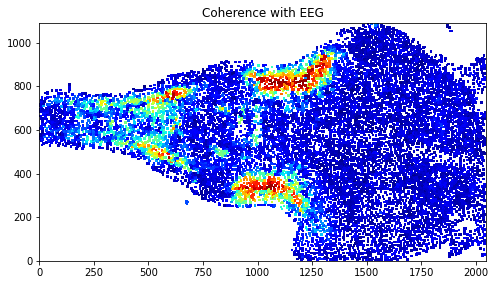

In [12]:
# Plot coherence with EEG of all cells

plt.figure(figsize=(8,5))
shift = 4
spaceMap=np.nan*np.ones(((np.ceil(np.max(y_loc+1))).astype(int),(np.ceil((np.max(x_loc+1)))).astype(int)))
for c in range(0,flouresence.shape[0]):
    if np.isnan(spaceMap[y_loc[c],x_loc[c]]):
        spaceMap[(np.maximum(np.ceil(y_loc[c]-shift).astype(int),1)).astype(int):(np.minimum(np.ceil(y_loc[c]+shift),(np.ceil(np.max(y_loc+1))).astype(int))).astype(int), (np.maximum(np.ceil(x_loc[c]-shift),1)).astype(int):(np.minimum(np.ceil(x_loc[c]+shift),(np.ceil(np.max(x_loc+1))).astype(int))).astype(int)] = coherence_est_cells[c]
    elif coherence_est_cells[c] >= spaceMap[y_loc[c],x_loc[c]]:  
        spaceMap[(np.maximum(np.ceil(y_loc[c]-shift).astype(int),1)).astype(int):(np.minimum(np.ceil(y_loc[c]+shift),(np.ceil(np.max(y_loc+1))).astype(int))).astype(int), (np.maximum(np.ceil(x_loc[c]-shift),1)).astype(int):(np.minimum(np.ceil(x_loc[c]+shift),(np.ceil(np.max(x_loc+1))).astype(int))).astype(int)] = coherence_est_cells[c]        
plt.pcolor(spaceMap,cmap="jet")
plt.gca().set_aspect('equal')
plt.title('Coherence with EEG')
plt.show

# Forming a null distribution to test statistical significance of coherence

In [13]:
# Forming null distribution to test statstical significance coherence

null_no_of_cells = np.minimum(10000,cells_all)
temp = np.random.permutation(cells_all)
selected_cells_null = temp[0:null_no_of_cells]
coherence_null = np.zeros((null_no_of_cells))
shift = 10

for n in range(0,null_no_of_cells):
    if n % 2000 == 0:
        print("No of cells analyzed: ",n)
    c = selected_cells_null[n]    
    plane_cell = data2[c,0]
    cross_eeg = 0 + 0j
    PSD_temp = 0
    temp_indices, = np.where(((np.maximum(np.ceil(y_loc[c]-shift).astype(int),1)).astype(int) <= y_loc) & ((np.minimum(np.ceil(y_loc[c]+shift),(np.ceil(np.max(y_loc+1))).astype(int))).astype(int) >= y_loc) & ((np.maximum(np.ceil(x_loc[c]-shift).astype(int),1)).astype(int) <= x_loc) & ((np.minimum(np.ceil(x_loc[c]+shift),(np.ceil(np.max(x_loc+1))).astype(int))).astype(int) >= x_loc) & (data2[:,0] == plane_cell))
#     if len(temp_indices)==0:
#         temp_indices = [c]
    for m_temp in range(0,M_analysed):
        m = swim_order[m_temp]
        shuffling_temp = np.random.permutation(W)
        if len(temp_indices) == 1:
            signal = flouresence[temp_indices,m*W:(m+1)*W]
            signal = signal.reshape((W,))
        else:
            signal = np.mean(flouresence[temp_indices,m*W:(m+1)*W], axis = 0)
        signal = signal[shuffling_temp]
        for taper in range(0,no_of_tapers):
            temp = (signal - np.mean(signal))*dpss_seq[taper,:]
            Fourier_est_temp = ((np.fft.fft(temp, n = 2*N)).T).reshape((2*N,)) 
            cross_eeg = cross_eeg + Fourier_est_temp[N_eeg_all[m]] * np.conj(((Fourier_est_eeg[N_eeg_all[m],m,plane_cell,taper])))
            PSD_temp = PSD_temp +  (np.absolute(Fourier_est_temp[N_eeg_all[m]]))**2
        cross_eeg = (1/no_of_tapers)*cross_eeg
        PSD_temp = (1/no_of_tapers)*PSD_temp
        coherence_null[n] = coherence_null[n] + (np.absolute(cross_eeg))**2/(PSD_temp * PSD_eeg_multitaper[N_eeg_all[m],m,plane_cell])

coherence_null = (1/M_analysed)*coherence_null


No of cells analyzed:  0
No of cells analyzed:  2000
No of cells analyzed:  4000
No of cells analyzed:  6000
No of cells analyzed:  8000


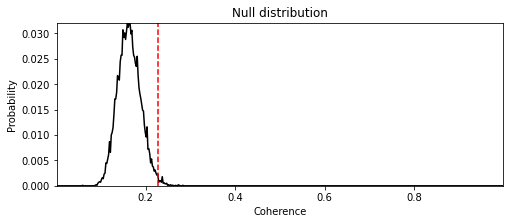

In [19]:
# Observing the null distribution

alpha = .01
no_of_bins = 500

hist_null, bin_edges = np.histogram(coherence_null, bins=no_of_bins, range=(0,1), density = True)

bin_edges_mid = bin_edges[:-1] + 1/(no_of_bins*2)

hist_null = hist_null/no_of_bins

hist_null_cum = np.cumsum(hist_null)
temp, = np.where(hist_null_cum > (1 - alpha))
significant_coherence_level = bin_edges_mid[temp[0]]

plt.figure(figsize=(8,3))
plt.plot(bin_edges_mid,hist_null,'k')
plt.plot([significant_coherence_level,significant_coherence_level],[0,np.max(hist_null)],'r--')
plt.autoscale(enable=True, tight=True)
plt.title('Null distribution')
plt.xlabel("Coherence")
plt.ylabel("Probability")
plt.show()


# Observe cells with Significant Coherence wrt EEG

<function matplotlib.pyplot.show(*args, **kw)>

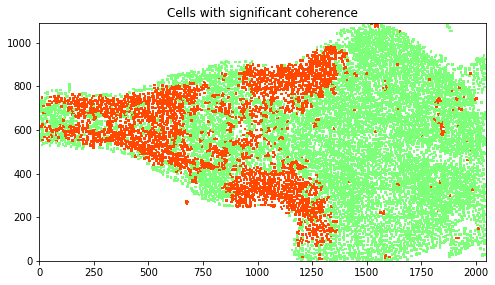

In [20]:
# Exract and observe cells that have significant coherence

selected_cells_significant_coherence, = np.where((coherence_est_cells > significant_coherence_level))

c_min = 0
c_max = 300
c_low = 150
c_high = 250
plt.figure(figsize=(8,5))
shift = 4
spaceMap=np.nan*np.ones(((np.ceil(np.max(y_loc+1))).astype(int),(np.ceil((np.max(x_loc+1)))).astype(int)))
for c in range(0,flouresence.shape[0]):
    if np.isnan(spaceMap[y_loc[c],x_loc[c]]) or spaceMap[y_loc[c],x_loc[c]] == c_low:
        if np.sum((c == selected_cells_significant_coherence)*1) > 0:
            spaceMap[(np.maximum(np.ceil(y_loc[c]-shift).astype(int),1)).astype(int):(np.minimum(np.ceil(y_loc[c]+shift),(np.ceil(np.max(y_loc+1))).astype(int))).astype(int), (np.maximum(np.ceil(x_loc[c]-shift),1)).astype(int):(np.minimum(np.ceil(x_loc[c]+shift),(np.ceil(np.max(x_loc+1))).astype(int))).astype(int)] = c_high
        else:
            spaceMap[(np.maximum(np.ceil(y_loc[c]-shift).astype(int),1)).astype(int):(np.minimum(np.ceil(y_loc[c]+shift),(np.ceil(np.max(y_loc+1))).astype(int))).astype(int), (np.maximum(np.ceil(x_loc[c]-shift),1)).astype(int):(np.minimum(np.ceil(x_loc[c]+shift),(np.ceil(np.max(x_loc+1))).astype(int))).astype(int)] = c_low            
plt.pcolor(spaceMap,cmap="jet",vmin=c_min, vmax=c_max)
plt.gca().set_aspect('equal')
plt.title('Cells with significant coherence')
plt.show
# plt.colorbar()

# Observe the magnitude and phase spectrograms

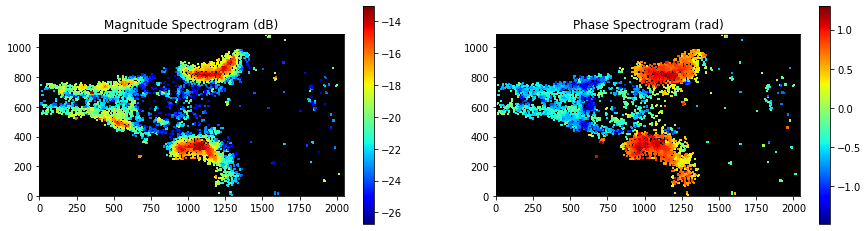

In [21]:
# Find and observe the magnitude and phase spectrograms of cells with significant coherence

mag_eeg_selected =  np.mean(10*np.log10(np.absolute(CPSD_cells_with_EEG[selected_cells_significant_coherence,:])), axis = 1)

phase_eeg_selected =  np.mean((np.angle(CPSD_cells_with_EEG[selected_cells_significant_coherence,:])), axis = 1)

plt.figure(figsize=(15,4))
plt.subplot(121,facecolor='k')
spaceMap=np.nan*np.ones(((np.ceil(np.max(y_loc+1))).astype(int),(np.ceil((np.max(x_loc+1)))).astype(int)))
for c in range(0,flouresence.shape[0]):
    if np.sum((c == selected_cells_significant_coherence)*1) > 0:
        temp, = np.where(c == selected_cells_significant_coherence)
        if np.isnan(spaceMap[y_loc[c],x_loc[c]]):
            spaceMap[(np.maximum(np.ceil(y_loc[c]-shift).astype(int),1)).astype(int):(np.minimum(np.ceil(y_loc[c]+shift),(np.ceil(np.max(y_loc+1))).astype(int))).astype(int), (np.maximum(np.ceil(x_loc[c]-shift),1)).astype(int):(np.minimum(np.ceil(x_loc[c]+shift),(np.ceil(np.max(x_loc+1))).astype(int))).astype(int)] = mag_eeg_selected[temp]
        else:
            spaceMap[(np.maximum(np.ceil(y_loc[c]-shift).astype(int),1)).astype(int):(np.minimum(np.ceil(y_loc[c]+shift),(np.ceil(np.max(y_loc+1))).astype(int))).astype(int), (np.maximum(np.ceil(x_loc[c]-shift),1)).astype(int):(np.minimum(np.ceil(x_loc[c]+shift),(np.ceil(np.max(x_loc+1))).astype(int))).astype(int)] = np.maximum(mag_eeg_selected[temp], spaceMap[y_loc[c],x_loc[c]])
plt.pcolor(spaceMap,cmap="jet")
plt.gca().set_aspect('equal')
plt.title("Magnitude Spectrogram (dB)")
plt.colorbar()
plt.subplot(122, facecolor='k')
spaceMap=np.nan*np.ones(((np.ceil(np.max(y_loc+1))).astype(int),(np.ceil((np.max(x_loc+1)))).astype(int)))
for c in range(0,flouresence.shape[0]):
    if np.sum((c == selected_cells_significant_coherence)*1) > 0:
        temp, = np.where(c == selected_cells_significant_coherence)
        spaceMap[(np.maximum(np.ceil(y_loc[c]-shift).astype(int),1)).astype(int):(np.minimum(np.ceil(y_loc[c]+shift),(np.ceil(np.max(y_loc+1))).astype(int))).astype(int), (np.maximum(np.ceil(x_loc[c]-shift),1)).astype(int):(np.minimum(np.ceil(x_loc[c]+shift),(np.ceil(np.max(x_loc+1))).astype(int))).astype(int)] = phase_eeg_selected[temp]
plt.pcolor(spaceMap,cmap="jet")
plt.gca().set_aspect('equal')
plt.title("Phase Spectrogram (rad)")
plt.colorbar()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
plt.show()

# Observe the phase sequence

10
9
8
7
6
5
4
3
2
1


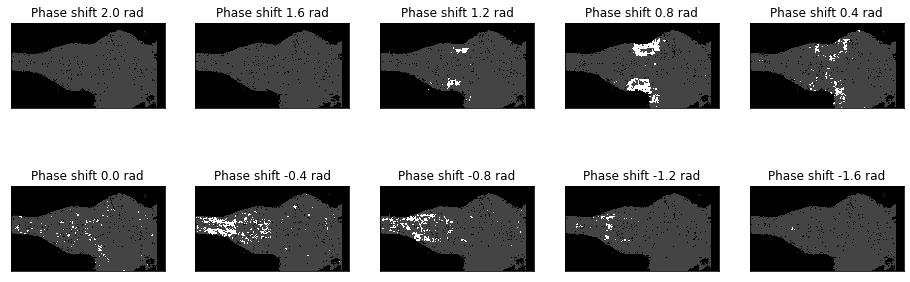

In [22]:
# Observe the phase sequence of the oscillating cells (Also I have plotted the actual shapes of the cells in this case)

c_min = 0
c_max = 300
c_low = 80
c_high = 300
phase_axis = np.linspace(-1.8,2.2,11)
P = len(phase_axis) - 1
x_loc1=data2[:,2]
y_loc1=data2[:,1]

plt.figure(figsize=(16,5))
for p in range(P,0,-1):
    print(p)
    phase_min = phase_axis[p-1]
    phase_max = phase_axis[p]
    temp = np.where((phase_eeg_selected >= phase_min) & (phase_eeg_selected < phase_max))
    closest_to_EEG_indices = selected_cells_significant_coherence[temp]
    spaceMap= np.zeros(((np.ceil(np.max(y_loc+1))+100).astype(int),(np.ceil((np.max(x_loc+1)))+100).astype(int)))
    plt.subplot(2,(np.ceil(P/2)).astype(int),P-p+1, facecolor='k')
    for c in range(0,flouresence.shape[0]):
        if np.sum((c == closest_to_EEG_indices)*1) > 0:
            spaceMap[y_loc1[c]:y_loc1[c]+100 ,x_loc1[c]:x_loc1[c]+100] = np.maximum(c_high*(1*(data1[c,:,:]>0)), spaceMap[y_loc1[c]:y_loc1[c]+100 ,x_loc1[c]:x_loc1[c]+100])
        else: 
            spaceMap[y_loc1[c]:y_loc1[c]+100 ,x_loc1[c]:x_loc1[c]+100] = np.maximum(c_low*(1*(data1[c,:,:]>0)), spaceMap[y_loc1[c]:y_loc1[c]+100 ,x_loc1[c]:x_loc1[c]+100])
    plt.pcolor(spaceMap, cmap="gray", vmin=c_min, vmax=c_max)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Phase shift %0.1f rad' %((phase_min+phase_max)/2))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=.5)
plt.savefig('phase_sequence_no_swim.png', bbox_inches = 'tight')
plt.show()
